In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math
from tqdm import tqdm

In [2]:
os.makedirs('../cleaned_data/splited_data', exist_ok=True)
os.makedirs('../cleaned_data/splited_data/test', exist_ok=True)
os.makedirs('../cleaned_data/splited_data/train', exist_ok=True)

In [3]:
check_in=pd.read_csv('../cleaned_data/filted_data/checkin.csv')

In [4]:
business=pd.read_csv('../cleaned_data/filted_data/business.csv')
tip=pd.read_csv('../cleaned_data/filted_data/tip.csv')
checkin=pd.read_csv('../cleaned_data/filted_data/checkin.csv')
user=pd.read_csv('../cleaned_data/filted_data/user.csv')


tip['date'] = pd.to_datetime(tip['date'])

for i in range(len(tip)):
    index=tip.index.values[i]
    tip.loc[index,'date']=tip.loc[index,'date'].timestamp()

In [5]:
len(tip)

83996

In [6]:
tip.head()

,user_id,business_id,text,date,compliment_count
0,OttfcRxgRrYsTg9EV5Aozg,clwjLY7PdYJpe7IP9lrqEw,Order the Tortilla Soup,1402968014.0,0
1,Y0JfJh4B-jrtGc_AHfWi6w,wUMuvdUeVZODZk7TjaD2jg,If the Hotlight is on you must stop in.,1362017154.0,0
2,bjX58cooXPxdNfR0GZ6r9Q,M1hsyjJDdQQeNP164FJ1pA,Everything is yummy!,1376936730.0,0
3,M0Hgcpkd5MxOaxLB3ELhXA,IiJ744MOUKmRYAgNFkcs0g,Great Pancakes!!!!!!,1396712856.0,0
4,xEM8BRJ4wm_s47Y0nL51MA,xv_U__GI9gmzKIHT_TANnw,"Best General Tso around. Also, try the grilled...",1312066471.0,0


In [7]:
import json

In [8]:
f = open('../cleaned_data/filted_data/review.json')
data = json.load(f)

In [9]:
print(f'type:{type(data)},\nkeys:{list(data.keys())},\ncolumns:{data["columns"]}')

type:<class 'dict'>,
keys:['columns', 'data'],
columns:['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']


In [10]:
df = pd.DataFrame(data['data'],columns =data['columns'])
df = df.astype({'date':'string'})
df['date'] = df['date'].str[:-3]
df = df.astype({'date':'int'})

**Select users whose reviews is over 5**

In [11]:
df=pd.concat([df, tip], ignore_index=True)
cou=df.groupby('user_id').count()
df['count']=cou['review_id']
cou[cou['review_id']>=5].index.values

array(['---UgP94gokyCDuB5zUssA', '--T_QxqWcEu76n1daMmlLQ',
       '--XwFm4qERD6J5SX0JAsbg', ..., 'zzawiLRYd4TjHKVyx6zjUQ',
       'zzgLgszu48af4NJULymzAA', 'zziWJMYwDjyVi7kJmgRUvg'], dtype=object)

In [12]:
df = df[df['user_id'].isin(cou[cou['review_id']>=5].index.values)] 
cou=cou[cou['review_id']>=5]

In [13]:
def Specific_row(user_id, df):
    temp = df[df['user_id'] == user_id]
    index = math.floor(len(temp) * 0.8)
    temp = temp.sort_values(by=['date'], ascending=True)
    return temp.iloc[index, :]

df2 = pd.DataFrame(columns=df.columns)

for i in tqdm(range(len(cou)), desc="Processing rows"):
    new_row = Specific_row(cou.index.values[i], df)
    df2.loc[len(df2)] = new_row

Processing rows:   0%|          | 6/24319 [00:00<15:30, 26.12it/s]

Processing rows: 100%|██████████| 24319/24319 [28:05<00:00, 14.43it/s]


In [14]:
df2.to_csv('../cleaned_data/splited_data/filtered.csv')

<Axes: ylabel='Density'>

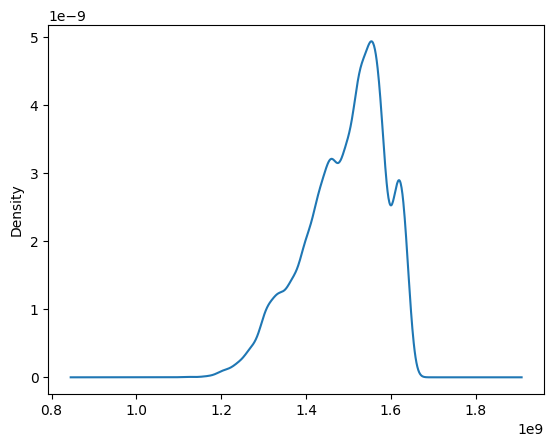

In [15]:
from datetime import datetime
import matplotlib.pyplot as plt
df2=pd.read_csv('../cleaned_data/splited_data/filtered.csv')
df2['date'].plot(kind='kde')

**Split data set by date**

In [16]:
train=df[df['date']<df2['date'].mean()]
test=df[df['date']>df2['date'].mean()]

In [17]:
test = test[test['user_id'].isin(set(train['user_id'].values))] 
test = test[test['business_id'].isin(set(train['business_id'].values))] 

In [18]:
df2['date'].mean()

1493000960.6406512

In [19]:
from datetime import datetime
df2['date2'] = [datetime.fromtimestamp(x) for x in df2['date']]

**Import Figure**

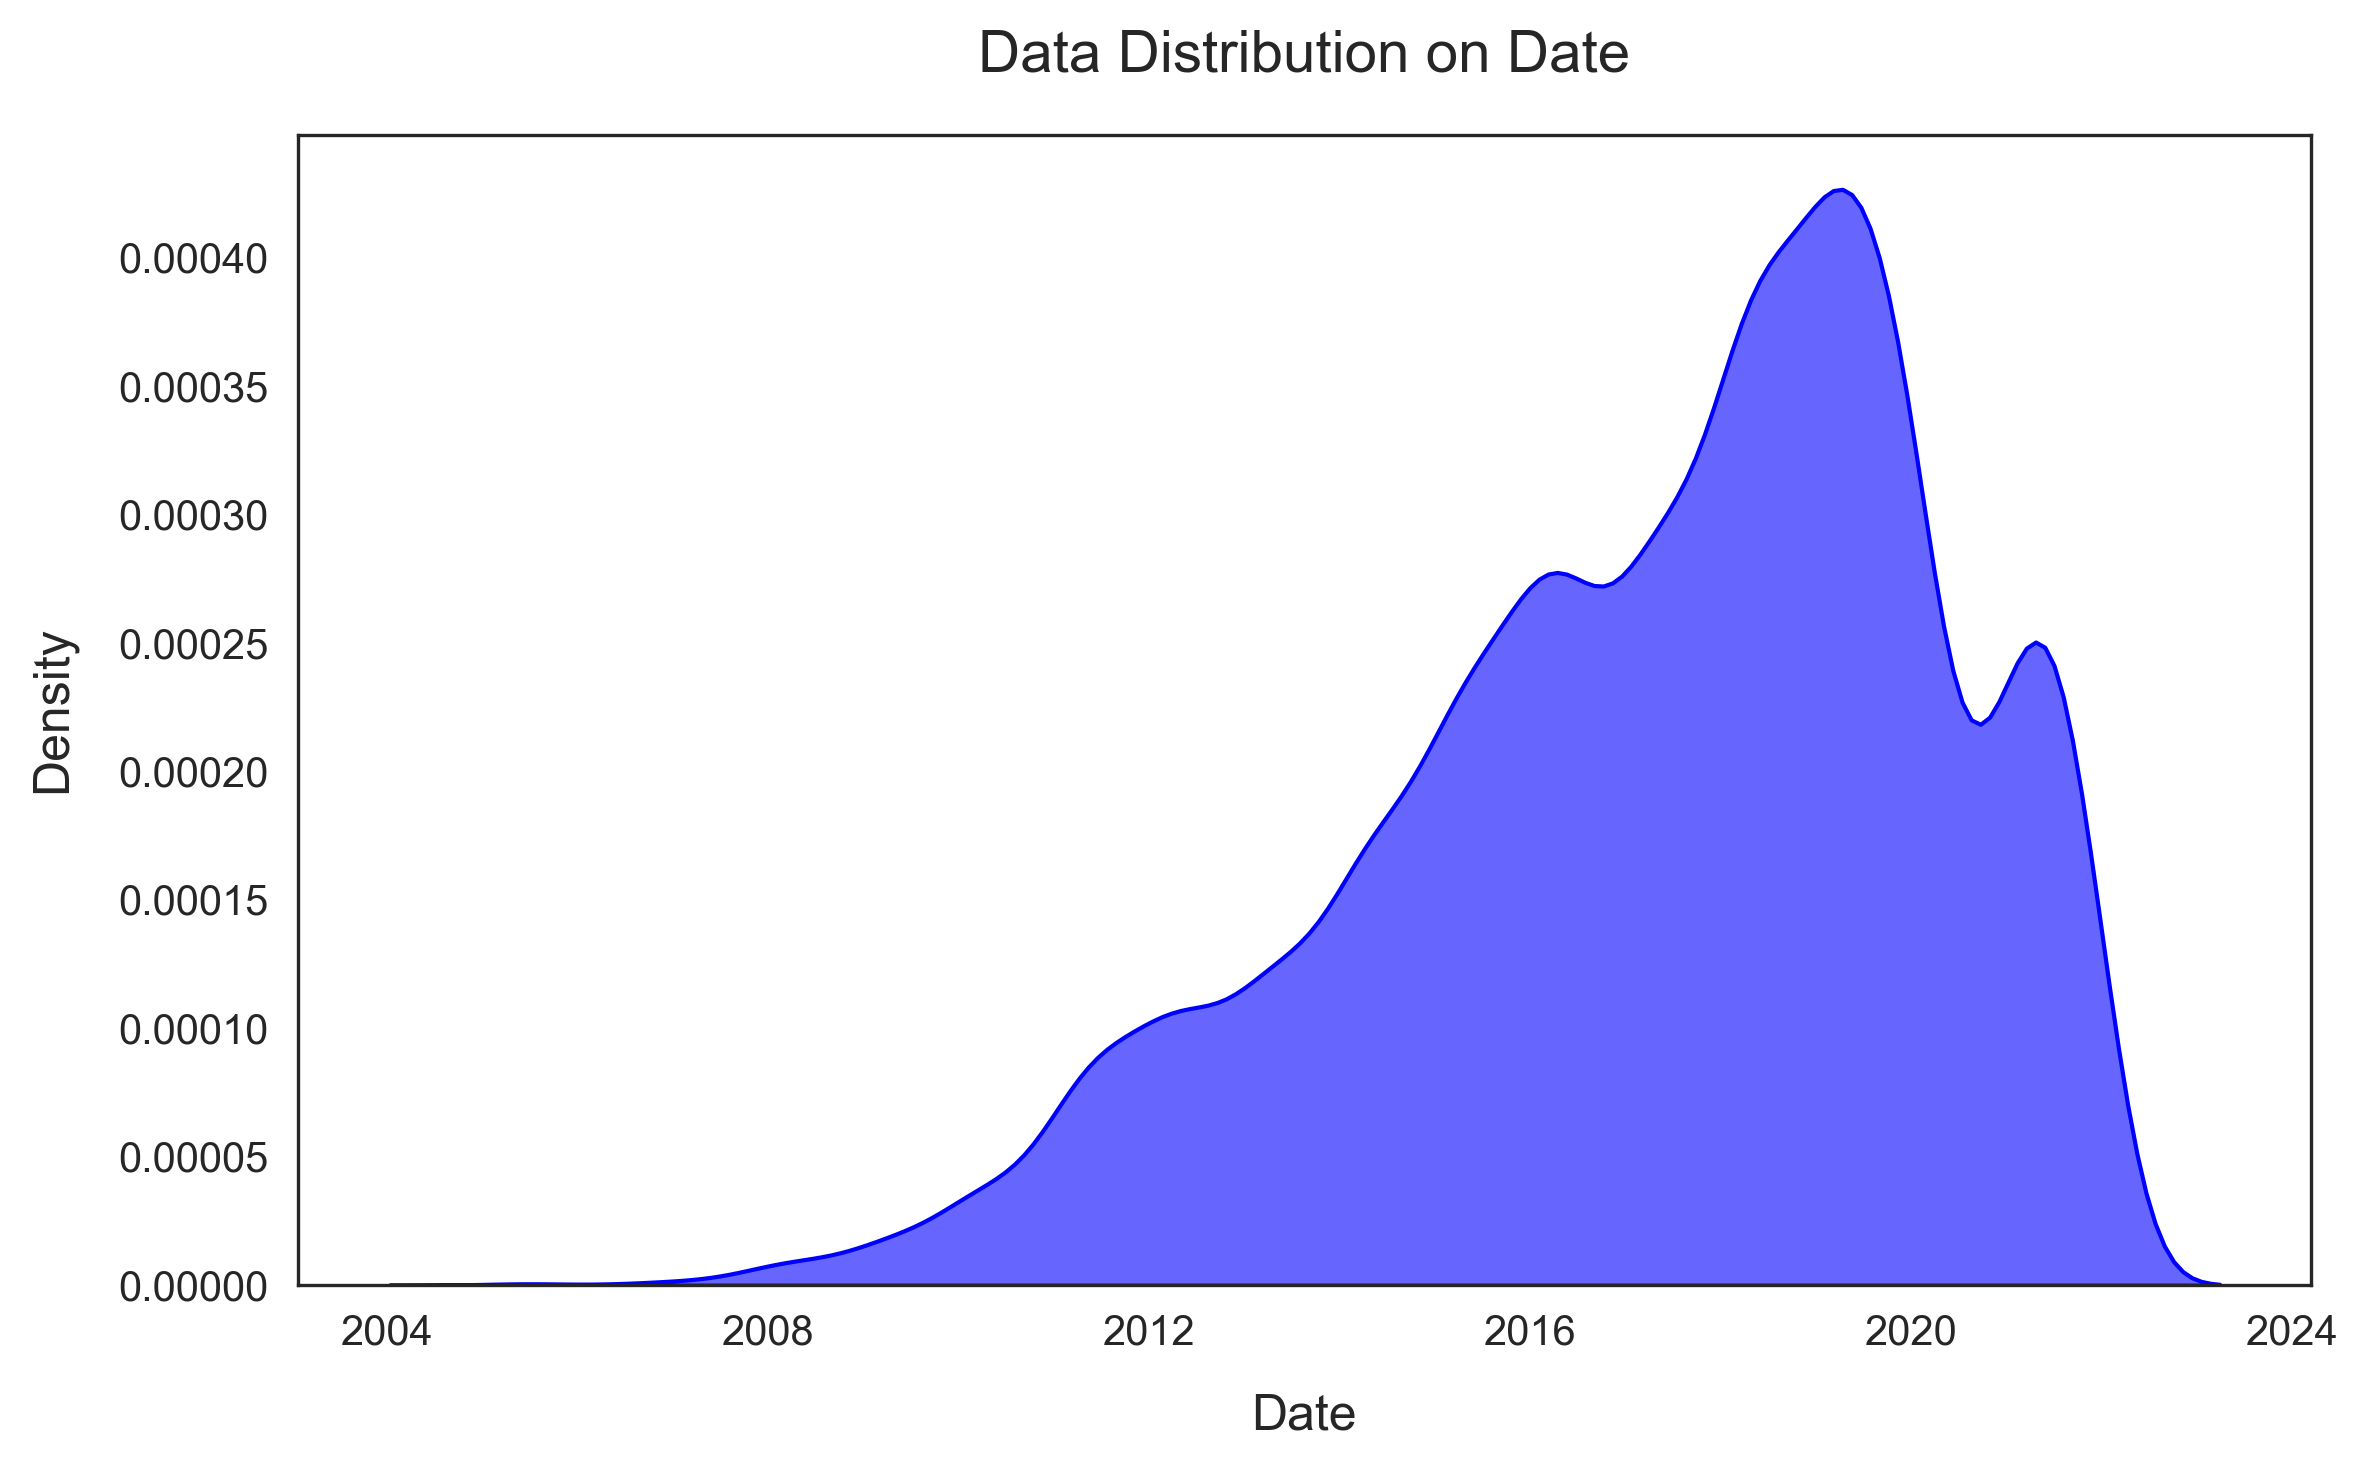

In [28]:
import seaborn as sns
plt.rcParams["figure.dpi"] = 300
sns.set_style("white")

fig, ax = plt.subplots(figsize=(8, 5))
sns.kdeplot(df2['date2'], ax=ax, color="blue", fill=True, alpha=0.6)

ax.set_xlabel("Date", fontsize=12, labelpad=10)
ax.set_ylabel("Density", fontsize=12, labelpad=10)

plt.title("Data Distribution on Date", fontsize=14, pad=15)

plt.tight_layout()

plt.show()

In [21]:
df2['date2'].head()

0   2020-10-08 00:14:15
1   2019-03-22 10:54:05
2   2019-05-27 06:23:20
3   2016-01-06 23:43:55
4   2018-10-24 01:08:30
Name: date2, dtype: datetime64[ns]

In [22]:
len(test)

47906

In [23]:
len(train)

189573

In [24]:
train.to_json("../cleaned_data/splited_data/train/review_train.json", orient="split", index=False)
test.to_json("../cleaned_data/splited_data/test/review_test.json", orient="split", index=False)
business=business[business['business_id'].isin(set(train['business_id'].values))] 

In [25]:
tip=tip[tip['business_id'].isin(set(train['business_id'].values))]
tip=tip[tip['user_id'].isin(set(train['user_id'].values))]
user=user[user['user_id'].isin(set(train['user_id'].values))]
check_in=check_in[check_in['business_id'].isin(set(train['business_id'].values))]

In [26]:
business.to_csv('../cleaned_data/splited_data/train/new_business.csv')
check_in.to_csv('../cleaned_data/splited_data/train/new_check_in.csv')
tip.to_csv('../cleaned_data/splited_data/train/new_tip.csv')
user.to_csv('../cleaned_data/splited_data/train/new_user.csv')

In [27]:
total=pd.concat([train,test])
total.to_csv('../cleaned_data/splited_data/new_total.csv')